329035
dt= 3.9935188773145
Bz [  1610  27361  35829  45161  49651  62319  81700  89563 111299 127577] [0.97991044 0.99035864 0.99042642 0.98789679 0.98075455 0.98771877
 0.98879781 0.98095766 0.98770587 0.98805398]
all [[  2329   1610]
 [ 27125  27361]
 [ 35855  35829]
 [ 45186  45161]
 [ 49792  49651]
 [ 62331  62319]
 [ 81657  81700]
 [ 90233  89563]
 [110509 111299]
 [127645 127577]] [0.97953363 0.99011026 0.98998928 0.98737131 0.98022808 0.98761078
 0.98847864 0.98034398 0.98727173 0.98757083]
The peak at 9305.235429 has prob 0.960244
The peak at 110235.434775 has prob 0.987991
The peak at 144575.703601 has prob 0.989964
The peak at 181841.225004 has prob 0.987348
The peak at 200003.748858 has prob 0.979479
The peak at 250336.064029 has prob 0.987605
The peak at 327624.631621 has prob 0.988408
The peak at 360449.360033 has prob 0.963558
The peak at 444337.217570 has prob 0.963848
The peak at 511056.937453 has prob 0.987395
630708
dt= 2.086621320585664
Bz [ 32128  52361  59644  6988

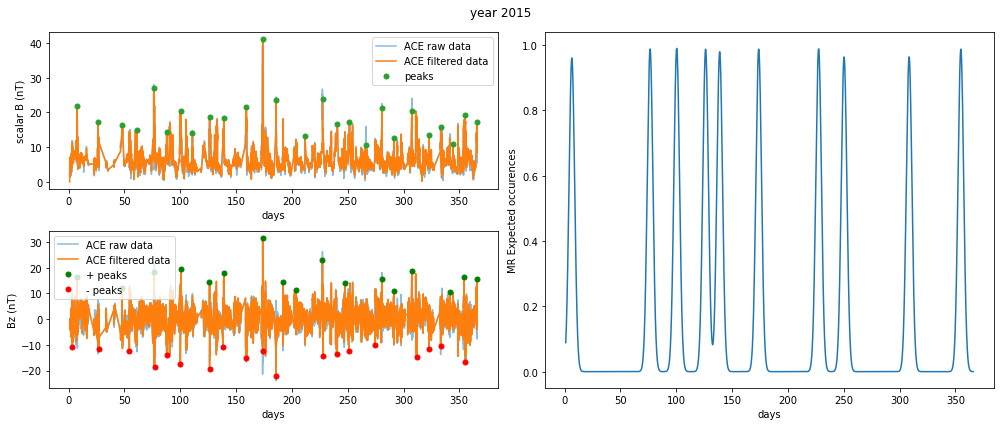

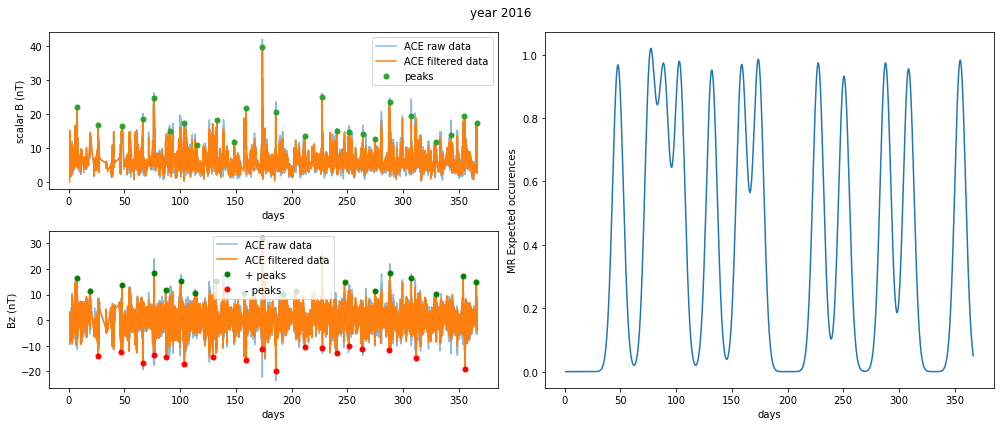

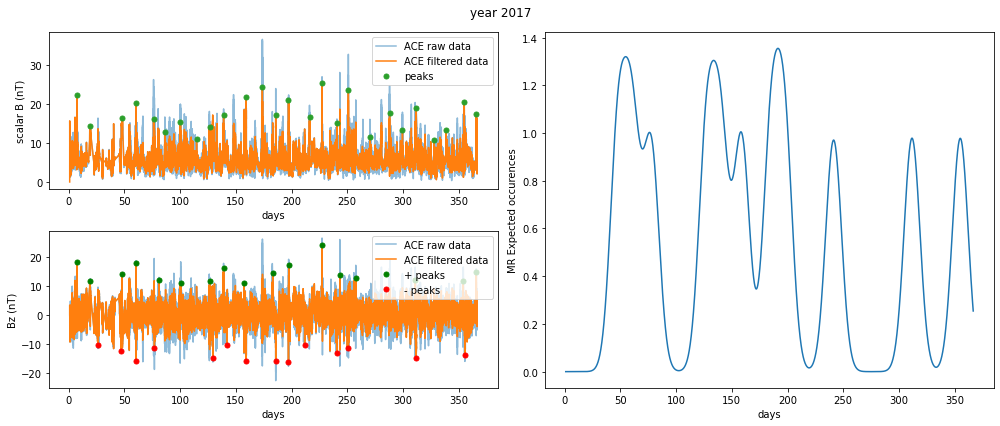

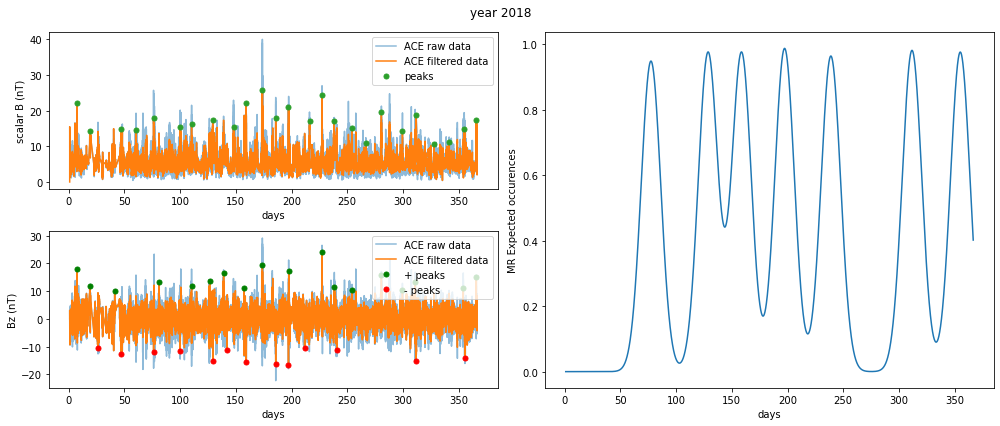

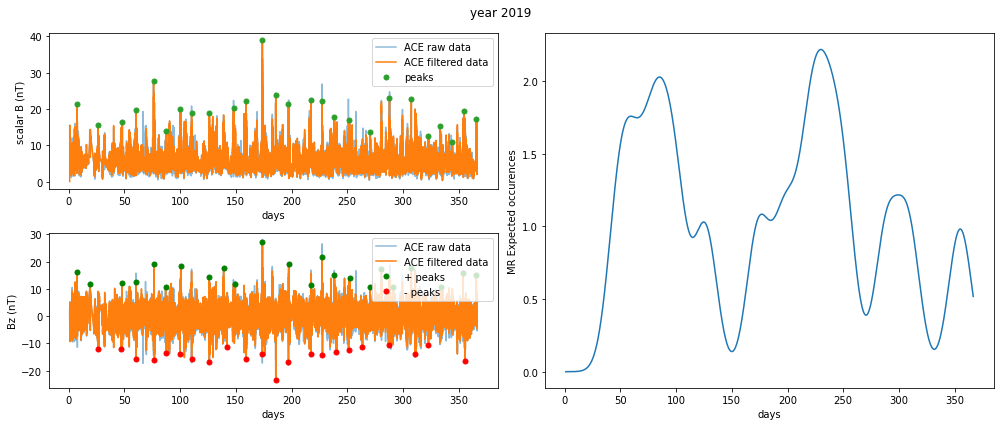

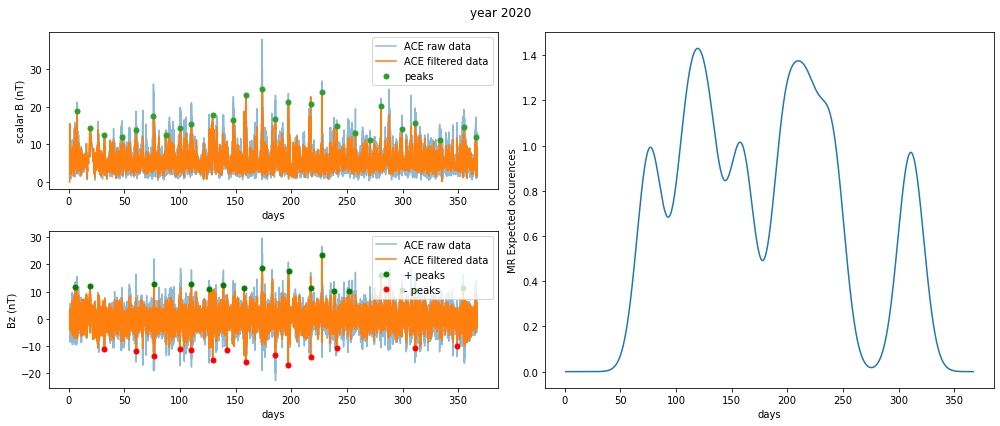

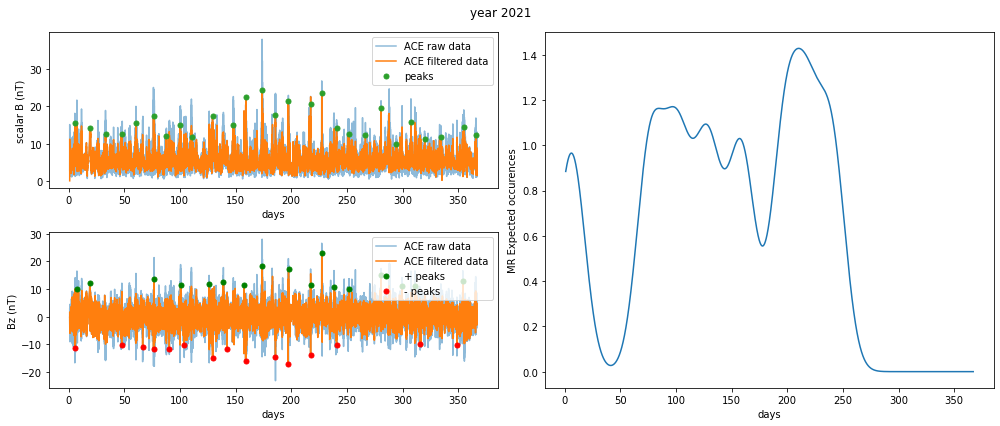

In [25]:
import numpy as np
import matplotlib.pyplot as plt

time, B0, By, Bz = [], [], [], []
year = 2015
for year in range(2015,2022):
    filename = "ACE_data/ACE_"+str(year)+".txt"
    save_dir = "ACE_plots/"
    # with open("sc_merge_min_Izr3EDhIyN.lst", "r") as file:
    with open(filename, "r") as file:
        def guass_dist(x, mu, sigma):
            return np.exp(-0.5*((x-mu)/sigma)**2) # /(sigma*np.sqrt(2*np.pi))


        file_read = np.loadtxt(file)
        for i in range(len(file_read)):
            if(np.abs(file_read[i,4]) < 100):
                time.append((60*(24*file_read[i,1] + file_read[i,2]) + file_read[i,3]))
                B0.append(file_read[i,4])
                By.append(file_read[i,5])
                Bz.append(file_read[i,6])
        original_sample = len(time)
        print(original_sample)
        num_sample = int(original_sample * 0.4)
        time_arr = np.linspace(np.min(time),np.max(time),num_sample)
        day_arr = time_arr / (24*60)
        dt = time_arr[1] - time_arr[0]
        print("dt=", dt)

        fig = plt.figure(figsize = (14,6))
        
#         fig_B0 = plt.figure(figsize=(6,4))
#         fig_Bz = plt.figure(figsize=(6,4))
#         fig_sp = plt.figure(figsize=(6,4))
#         ax_B0 = fig_B0.gca()
#         ax_Bz = fig_Bz.gca()
#         ax_sp = fig_sp.gca()
        ax_B0 = fig.add_subplot(221)
        ax_Bz = fig.add_subplot(223)
        ax_sp = fig.add_subplot(122)

        from scipy import interpolate
        B0_of_t = interpolate.interp1d(np.array(time),np.array(B0))
        B0_arr = B0_of_t(time_arr)
        Bz_of_t = interpolate.interp1d(np.array(time),np.array(Bz))
        Bz_arr = Bz_of_t(time_arr)


        from scipy.signal import butter, lfilter, freqz

        def lpfilter(t,data):


            num_sample = len(t)
            fs = num_sample / (np.max(t)-np.min(t))

            ## customizable
            order = 6
            cutoff = 0.1*fs  # desired cutoff frequency of the filter, Hz

            def butter_lowpass(cutoff, fs, order=5):
                return butter(order, cutoff, fs=fs, btype='low', analog=False)

            def butter_lowpass_filter(data, cutoff, fs, order=5):
                b, a = butter_lowpass(cutoff, fs, order=order)
                y = lfilter(b, a, data)
                return y

            b, a = butter_lowpass(cutoff, fs, order)
            data_filter  = butter_lowpass_filter(data, cutoff,fs)

            noise = data - data_filter
            return data_filter, noise


        from scipy.signal import find_peaks

        ## customizable
        peak_d = int(10*24*60 / dt) #10 days
        peak_d_time = peak_d * dt
        peak_h = 10

        def get_peaks(data_):
            peaks, _ = find_peaks(data_, distance=peak_d,height=peak_h)
            return peaks


        # first condition
        B0_filter, B0_noise = lpfilter(time_arr, B0_arr)
        Bz_filter, Bz_noise = lpfilter(time_arr, Bz_arr)

        B0_noise_rms = np.sqrt(np.sum(B0_noise**2)/len(B0_noise))
        Bz_noise_rms = np.sqrt(np.sum(Bz_noise**2)/len(Bz_noise))


        B0_peaks = get_peaks(B0_filter)
        B0_probs = guass_dist(B0_noise_rms,0,B0_filter[B0_peaks])
    #     print("B0", B0_peaks, B0_probs)

        ax_B0.plot(day_arr,B0_arr,alpha=0.5,label="ACE raw data")
        ax_B0.plot(day_arr,B0_filter,label="ACE filtered data")
        ax_B0.plot(day_arr[B0_peaks],B0_filter[B0_peaks],".",markersize=10,label="peaks")




        # second condition
        Bp_filter = np.clip(Bz_filter,a_min=0,a_max=None)
        Bm_filter = np.clip(Bz_filter,a_max=0,a_min=None)

        Bp_peaks = get_peaks(np.abs(Bp_filter))
        Bm_peaks = get_peaks(np.abs(Bm_filter))
        Bp_probs = guass_dist(Bz_noise_rms,0,np.abs(Bp_filter[Bp_peaks]))
        Bm_probs = guass_dist(Bz_noise_rms,0,np.abs(Bm_filter[Bm_peaks]))

        Bz_peaks = []

        ax_Bz.plot(day_arr,Bz_arr,alpha=0.5,label="ACE raw data")
        ax_Bz.plot(day_arr,Bz_filter,label="ACE filtered data")
        ax_Bz.plot(day_arr[Bp_peaks],Bz_filter[Bp_peaks],"g.",markersize=10,label="+ peaks")
        ax_Bz.plot(day_arr[Bm_peaks],Bz_filter[Bm_peaks],"r.",markersize=10,label="- peaks")

        def check_peaks(tup1, tup2, dist):
            peaks1, probs1 = tup1
            peaks2, probs2 = tup2
            peaks = []
            probs = []
            if(len(peaks1) > 0 and len(peaks2) > 0):
                for i, peak1 in enumerate(peaks1):
                    for j, peak2 in enumerate(peaks2):
                        if(np.abs(peak2-peak1) < dist):
                            peaks.append([peak1,peak2])
                            probs.append(probs1[i]*probs2[j])

            return np.array(peaks), np.array(probs)



        Bz_peaks_pairs, Bz_probs = check_peaks((Bp_peaks,Bp_probs),(Bm_peaks,Bm_probs),peak_d/2)
        Bz_peaks = np.array([np.mean(Bz_pairs,dtype = int) for Bz_pairs in Bz_peaks_pairs])
        print("Bz", Bz_peaks, Bz_probs)

        peaks_all, probs_all = check_peaks((B0_peaks,B0_probs), (Bz_peaks,Bz_probs), peak_d/2)
        print("all", peaks_all, probs_all)
        prob_spect = np.zeros_like(time_arr)
        for i, peak_all in enumerate(peaks_all):
            peak_prob = guass_dist(peak_all[0], peak_all[1], peak_d)* probs_all[i]
            peak_time = (time_arr[peak_all[0]] + time_arr[peak_all[1]])/2
            print("The peak at %f has prob %f" % (peak_time , peak_prob))

            prob_spect += guass_dist(time_arr,peak_time, peak_d) * peak_prob 
        ax_sp.plot(day_arr,prob_spect)
        ax_sp.set_xlabel("days")
        ax_B0.set_xlabel("days")
        ax_Bz.set_xlabel("days")
        ax_sp.set_ylabel("MR Expected occurences")
        ax_B0.set_ylabel("scalar B (nT)")
        ax_Bz.set_ylabel("Bz (nT)")
        ax_B0.legend()
        ax_Bz.legend()
        plt.suptitle("year %d" % year)
        plt.tight_layout()
        fig.savefig(save_dir + "fig_" + str(year) + ".png")